In [ ]:
import os
import sys
import time
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

In [ ]:
#Model1
class ConvNet(nn.Module):


    def __init__(self):

        super(ConvNet, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""

        # conv layers
        x = self.conv_layer(x)

        # flatten
        x = x.view(x.size(0), -1)

        # fc layer
        x = self.fc_layer(x)

        # return output
        return x

In [ ]:
#Model 2
class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=10):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def DenseNet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def DenseNet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def DenseNet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def DenseNet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

def densenet_cifar():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=12)

In [ ]:
# Training
def train(epoch,num_of_epochs):
    print('\nEpoch: %d/%d' % ((epoch+1), num_of_epochs))
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        progress_bar(batch_idx+1, len(trainloader), train_loss/(batch_idx+1), 100*correct/total, 'Train')

In [ ]:
def test(epoch):
    #print("Test Results:")
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

           #progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            progress_bar(batch_idx+1, len(testloader), test_loss/(batch_idx+1), 100*correct/total, 'Test ')

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('\nSaving...', end = ' ')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    print("Done!")

In [ ]:
def progress_bar(batch_idx_plus_one, len_tr_ld, loss, acc, sts_str):
    str_prnt_len = 50
    str_eqls_len = str_prnt_len*batch_idx_plus_one//len_tr_ld-1
    str_eqls = '='*str_eqls_len
    str_dots = '.'*(str_prnt_len-str_eqls_len-1)
    str_print = str_eqls + '>' + str_dots
    print('{:s}  {:s} Steps: {:3d}/{:3d}   Loss: {:4.2f}   Accuracy: {:4.2f}% '.format(
        str_print, sts_str, batch_idx_plus_one, len_tr_ld, loss, acc), end ='\r')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 0, 2)))  # convert from Tensor image

In [ ]:
# Data
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


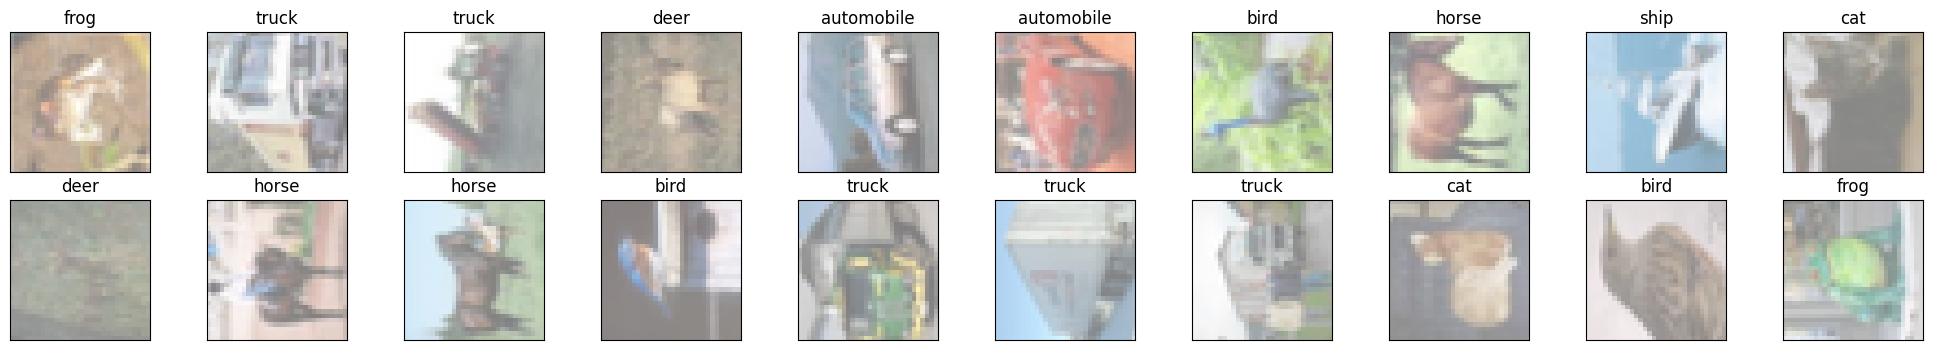

In [ ]:
# Visualization Cell
#dataiter = iter(trainloader)
#images, labels = dataiter.next()
#images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    image = trainset.data[idx]/255
    label = trainset.targets[idx]
    imshow(image)
    ax.set_title(trainset.classes[label])

In [ ]:
lr = 0.1
resume = 0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("The device is:",device)
best_acc = 0  # best test accuracy
start_epoch = 5  # start from epoch 0 or last checkpoint epoch
num_of_epochs = 10

The device is: cuda


In [ ]:
# Model
print('==> Building model...', end = ' ')
### net = ResNet18()
net = DenseNet121()
### net = ConvNet()
net = net.to(device)
print("Done!")

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

print('==> Building Optimizer and Loss Objects ...', end = ' ')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
print("Done!")

==> Building model... Done!
==> Building Optimizer and Loss Objects ... Done!


In [ ]:
for epoch in range(start_epoch, start_epoch+num_of_epochs):
    train(epoch, num_of_epochs)
    print()
    test(epoch)
    scheduler.step()


Epoch: 6/10
=================================================>  Train Steps: 391/391   Loss: 1.70   Accuracy: 38.05% 
=================================================>  Test  Steps: 100/100   Loss: 1.46   Accuracy: 46.36% 
Saving... Done!

Epoch: 7/10
=================================================>  Train Steps: 391/391   Loss: 1.19   Accuracy: 56.81% 
=================================================>  Test  Steps: 100/100   Loss: 1.22   Accuracy: 57.69% 
Saving... Done!

Epoch: 8/10
=================================================>  Train Steps: 391/391   Loss: 0.90   Accuracy: 67.97% 
=================================================>  Test  Steps: 100/100   Loss: 1.02   Accuracy: 65.05% 
Saving... Done!

Epoch: 9/10
